In [1]:
import os
import numpy as np

train1_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/MNIST_mni/train'
test1_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/MNIST_mni/test'

In [2]:
train2_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/Original/USPS_categorize/train'
test2_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/Original/USPS_categorize/test'

In [3]:
train3_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/SVHN_mni/train'
test3_dir = 'C:/Users/KIMHAKBIN/A_My Python/Datacloud/digits/SVHN_mni/test'

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

def generate_generator_multiple(generator, dir1, dir2, dir3):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (28,28),
                                          batch_size=64,
                                          color_mode="grayscale",
                                          class_mode='categorical')
    
    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (28,28),
                                          batch_size=64,
                                          color_mode="grayscale",
                                          class_mode='categorical')
    
    genX3 = generator.flow_from_directory(dir3,
                                          target_size = (28,28),
                                          batch_size=64,                                          
                                          class_mode='categorical')
    
    while True:
        X_1, Y_1 = genX1.next()
        X_2, Y_2 = genX2.next()
        X_3, Y_3 = genX3.next()
        
        X_1 = np.tile(X_1, [1,1,1,3])
        X_2 = np.tile(X_2, [1,1,1,3])
        
        
        yield [X_1, X_2, X_3],[Y_1, Y_2, Y_3]

Using TensorFlow backend.


In [5]:
inputgenerator=generate_generator_multiple(generator=train_datagen,
                                           dir1=train1_dir,
                                           dir2=train2_dir,
                                           dir3=train3_dir)

In [6]:
testgenerator=generate_generator_multiple(generator=test_datagen,
                                           dir1=test1_dir,
                                           dir2=test2_dir,
                                           dir3=test3_dir)

In [7]:
# mdoel1
from keras.models import Model
from keras import layers
from keras import Input

# input1 주입
input_MNIST = Input(shape=(28, 28, 3))
# input2 주입
input_USPS = Input(shape=(28, 28, 3))
# input3 주입
input_SVHN = Input(shape=(28, 28, 3))


## private layer에 data 주입

# MNIST
x_1 = layers.Conv2D(32, (3, 3), activation='relu')(input_MNIST)
x_1 = layers.Conv2D(32, (3, 3), activation='relu')(x_1)
x_1 = layers.MaxPooling2D((2,2))(x_1)

# USPS
x_2 = layers.Conv2D(32, (3, 3), activation='relu')(input_USPS)
x_2 = layers.Conv2D(32, (3, 3), activation='relu')(x_2)
x_2 = layers.MaxPooling2D((2,2))(x_2)

# SVHN
x_3 = layers.Conv2D(32, (3, 3), activation='relu')(input_SVHN)
x_3 = layers.Conv2D(32, (3, 3), activation='relu')(x_3)
x_3 = layers.MaxPooling2D((2,2))(x_3)

x_3 = layers.Conv2D(64, (3, 3), activation='relu')(x_3)
x_3 = layers.Conv2D(64, (3, 3), activation='relu')(x_3)
x_3 = layers.MaxPooling2D((2,2))(x_3)


# shared layer(MNIST, USPS) 생성

sh_MU_conv1 = layers.Conv2D(64, (3, 3), activation='relu')
sh_MU_conv2 = layers.Conv2D(64, (3, 3), activation='relu')
sh_MU_MaxPool1 = layers.MaxPooling2D((2,2))

# shared layer(MNIST, USPS)에 data 주입

x_1 = sh_MU_conv1(x_1)
x_1 = sh_MU_conv2(x_1)
x_1 = sh_MU_MaxPool1(x_1)

x_2 = sh_MU_conv1(x_2)
x_2 = sh_MU_conv2(x_2)
x_2 = sh_MU_MaxPool1(x_2)


# shared layer(ALL) 생성

sh_Flatten =layers.Flatten()
sh_Dense128 =layers.Dense(128, activation='relu')
sh_Dense10 = layers.Dense(10, activation='softmax')

# shared layer(ALL)에 data 주입

x_1 = sh_Flatten(x_1)
x_1 = sh_Dense128(x_1)
output_1 = sh_Dense10(x_1)

x_2 = sh_Flatten(x_2)
x_2 = sh_Dense128(x_2)
output_2 = sh_Dense10(x_2)

x_3 = sh_Flatten(x_3)
x_3 = sh_Dense128(x_3)
#x_3 = sh_Dropout(x_3)
output_3 = sh_Dense10(x_3)





model = Model([input_MNIST, input_USPS, input_SVHN], [output_1, output_2, output_3])

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
from keras.optimizers import Optimizer
from keras_lr_multiplier import LRMultiplier


multipliers = {'conv2d_1': 0.333}
# LRMultiplier('rmsprop', multipliers)
model.compile(optimizer='rmsprop',
             loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
             metrics=['acc', 'acc', 'acc'])

In [10]:
history = model.fit_generator(inputgenerator,
                             steps_per_epoch=120,
                             epochs=60,
                             validation_data=testgenerator,
                             validation_steps=35)

Epoch 1/60
Found 2007 images belonging to 10 classes.
Found 2007 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
Found 2007 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
120/120 [==============================] - 19s 158ms/step - loss: 3.0017 - dense_2_loss: 1.9760 - dense_2_acc: 0.8324 - dense_2_acc_1: 0.8324 - dense_2_acc_2: 0.8324 - dense_2_acc_3: 0.8489 - dense_2_acc_4: 0.8489 - dense_2_acc_5: 0.8489 - dense_2_acc_6: 0.3046 - dense_2_acc_7: 0.3046 - dense_2_acc_8: 0.3046 - val_loss: 1.6951 - val_dense_2_loss: 1.2660 - val_dense_2_acc: 0.9450 - val_dense_2_acc_1: 0.9450 - val_dense_2_acc_2: 0.9450 - val_dense_2_acc_3: 0.9336 - val_dense_2_acc_4: 0.9336 - val_dense_2_acc_5: 0.9336 - val_dense_2_acc_6: 0.6035 - val_dense_2_acc_7: 0.6035 - val_dense_2_acc_8: 0.6035
Epoch 2/60
120/120 [==============================] - 16s 129ms/step - loss: 1.2624 - dense_2_loss: 1.0213 - dense_2_acc: 0.9

Epoch 14/60
120/120 [==============================] - 15s 129ms/step - loss: 0.1212 - dense_2_loss: 0.1034 - dense_2_acc: 0.9969 - dense_2_acc_1: 0.9969 - dense_2_acc_2: 0.9969 - dense_2_acc_3: 0.9980 - dense_2_acc_4: 0.9980 - dense_2_acc_5: 0.9980 - dense_2_acc_6: 0.9678 - dense_2_acc_7: 0.9678 - dense_2_acc_8: 0.9678 - val_loss: 1.4263 - val_dense_2_loss: 1.0672 - val_dense_2_acc: 0.9741 - val_dense_2_acc_1: 0.9741 - val_dense_2_acc_2: 0.9741 - val_dense_2_acc_3: 0.9613 - val_dense_2_acc_4: 0.9613 - val_dense_2_acc_5: 0.9613 - val_dense_2_acc_6: 0.8104 - val_dense_2_acc_7: 0.8104 - val_dense_2_acc_8: 0.8104
Epoch 15/60
120/120 [==============================] - 15s 127ms/step - loss: 0.1135 - dense_2_loss: 0.0924 - dense_2_acc: 0.9979 - dense_2_acc_1: 0.9979 - dense_2_acc_2: 0.9979 - dense_2_acc_3: 0.9966 - dense_2_acc_4: 0.9966 - dense_2_acc_5: 0.9966 - dense_2_acc_6: 0.9721 - dense_2_acc_7: 0.9721 - dense_2_acc_8: 0.9721 - val_loss: 1.5784 - val_dense_2_loss: 1.2057 - val_dense_2_

120/120 [==============================] - 16s 129ms/step - loss: 0.0319 - dense_2_loss: 0.0210 - dense_2_acc: 0.9986 - dense_2_acc_1: 0.9986 - dense_2_acc_2: 0.9986 - dense_2_acc_3: 0.9986 - dense_2_acc_4: 0.9986 - dense_2_acc_5: 0.9986 - dense_2_acc_6: 0.9944 - dense_2_acc_7: 0.9944 - dense_2_acc_8: 0.9944 - val_loss: 2.1755 - val_dense_2_loss: 1.6102 - val_dense_2_acc: 0.9723 - val_dense_2_acc_1: 0.9723 - val_dense_2_acc_2: 0.9723 - val_dense_2_acc_3: 0.9641 - val_dense_2_acc_4: 0.9641 - val_dense_2_acc_5: 0.9641 - val_dense_2_acc_6: 0.8236 - val_dense_2_acc_7: 0.8236 - val_dense_2_acc_8: 0.8236
Epoch 41/60
120/120 [==============================] - 15s 128ms/step - loss: 0.0309 - dense_2_loss: 0.0211 - dense_2_acc: 0.9991 - dense_2_acc_1: 0.9991 - dense_2_acc_2: 0.9991 - dense_2_acc_3: 0.9980 - dense_2_acc_4: 0.9980 - dense_2_acc_5: 0.9980 - dense_2_acc_6: 0.9941 - dense_2_acc_7: 0.9941 - dense_2_acc_8: 0.9941 - val_loss: 2.2679 - val_dense_2_loss: 1.7487 - val_dense_2_acc: 0.9718 

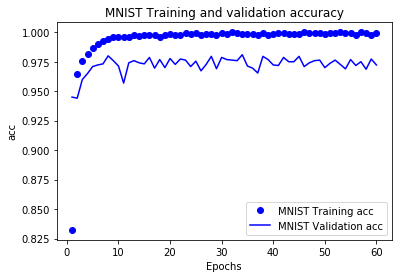

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

dense_2_acc = history_dict['dense_2_acc']
val_dense_2_acc = history_dict['val_dense_2_acc']

epochs = range(1, len(dense_2_acc) + 1)

plt.plot(epochs, dense_2_acc, 'bo', label = 'MNIST Training acc')
plt.plot(epochs, val_dense_2_acc, 'b', label = 'MNIST Validation acc')
plt.title('MNIST Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

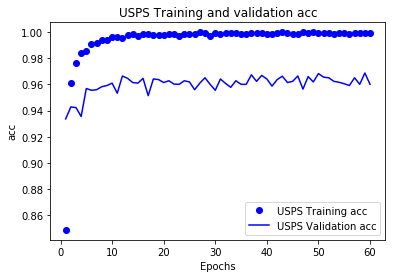

In [16]:
plt.clf()

dense_4_acc = history_dict['dense_2_acc_3']
val_dense_4_acc = history_dict['val_dense_2_acc_3']

plt.plot(epochs, dense_4_acc, 'bo', label = 'USPS Training acc')
plt.plot(epochs, val_dense_4_acc, 'b', label = 'USPS Validation acc')
plt.title('USPS Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

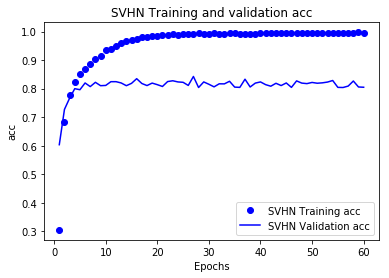

In [17]:
plt.clf()

dense_6_acc = history_dict['dense_2_acc_6']
val_dense_6_acc = history_dict['val_dense_2_acc_6']

plt.plot(epochs, dense_6_acc, 'bo', label = 'SVHN Training acc')
plt.plot(epochs, val_dense_6_acc, 'b', label = 'SVHN Validation acc')
plt.title('SVHN Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

In [28]:
loss = history_dict['val_loss']
loss.index(min(loss))

5

In [33]:
print('MNIST Val acc')
print(val_dense_2_acc[5])
print()

print('USPS Val acc')
print(val_dense_4_acc[5])
print()

print('SVHN Val acc')
print(val_dense_6_acc[5])

MNIST Val acc
0.9722601182355616

USPS Val acc
0.9554342885297122

SVHN Val acc
0.8199181448551349
